In [128]:
import tweepy #Api package handler
import pandas as pd #Used for csv files
import time #Will be used for Chronometer
import datetime #Will be used for Getting date form
import matplotlib.pyplot as plt
%matplotlib inline

In [129]:
""" Api Consumer Class"""
class TwitterApiSearch:
    #'Count how many rows received from api'
    total_found_post = 0
    #start chronometer
    start_time = 0 #start chronometer
    end_time = 0 #end chronometer
    
    #Storing api result in array
    tweets_array = [] 
    #Collect all posts trends
    hashtags_collection = []
    
    def __init__(self, api, keyword_array, nb_record=''):
        self.api = api
        self.keyword_array = keyword_array
        self.nb_records = nb_record
    
    def __getDataFromApi(self):
        self.start_time = time.time()
        
        for key in self.keyword_array:
            for tweet in tweepy.Cursor(self.api.search, q = key).items(self.nb_records):
                #check if post has hashtag
                is_hashtag = len(tweet.entities['hashtags'])
                #get first hashtag only if there is an hashtag
                hashtag = tweet.entities['hashtags'][0]['text'] if is_hashtag!=0 else ''
                
                created_at = tweet.created_at
                text = tweet.text
                username = tweet.user.screen_name
        
                #store tweet record
                self.tweets_array.append([key, created_at, text, username, hashtag])
                #store tweet tag
                self.hashtags_collection.append(hashtag) 
                
                #track records got as an api resonse total++
                self.total_found_post = self.total_found_post + 1 
            
        self.end_time = time.time() #chrono ends
        
    def getTweets(self):
        self.__getDataFromApi()
        return self.tweets_array
    
    def getHashtags(self):
        return self.hashtags_collection
    
    def getTotalRows(self):
        return self.total_found_post
    
    def getChronoRecord(self):
        record = self.end_time - self.start_time
        return record

In [130]:
""" Connect to Api"""
def twitterApiConnection(api_key, api_key_secret):
    #Send OAuth request
    auth = tweepy.AppAuthHandler(api_key, api_key_secret) 
    #Create API object
    api = tweepy.API(auth) 
    
    return api

In [131]:
""" Conver input to List"""
def inputToList(string):
    #Prepare input to convert it into array
    string = string.replace(', ', ',').replace(' ,', ',') 
    #conver input to array
    array = string.split(',')
    
    return array

In [132]:
""" List to string """
#Array to string
def listToString(L):  
    return ", ".join(str(x) for x in L)

In [133]:
""" Remove empty elements from list """
def removeEmptyFromList(L):
    return [string for string in L if string != ""]

In [134]:
""" Get array with occurence, and with no duplications"""
def arrayOccurences(array):
    array_occurence = []
    no_duplications = list(set(array))
    for item in no_duplications:
        array_occurence.append([item, array.count(item)])
    
    return {'without_duplications': no_duplications, 'array_occurence': array_occurence}

In [135]:
""" Twitter array with occurences of registered hashtags """
def tweetWithHashtagOccurence(input_array, hashtags_array, target_column_index):
    final_array =[]
    columns = len(input_array[0])
    target_column = arrayOccurences(hashtags_array)
    target_no_duplication = target_column['without_duplications']
    target_occurence = target_column['array_occurence']
    
    for item in input_array:
        name = item[target_column_index]
        index = target_no_duplication.index(name)
        occurence = target_occurence[index][1]
        
        final_array.append([item[0], item[1], item[2], item[3], item[4], occurence])
    return final_array

In [136]:
""" Create csv file from twitter's given array"""
def createTweetCsv(array, filename, display_message=False):
    fieldnames = ["keyword", "created_at", "text", "username", "hashtag", "hashtag_occurence"]
    df = pd.DataFrame(array, columns = fieldnames)
    df.to_csv(filename, index=False)
    
    if display_message:
            print('file ', end=" ")
            print('\033[4m' + filename + '\033[0m' , end=" ")
            print(' has been successfully created')

In [137]:
""" Sort tweet's array by column """
def tweetSortedByColumn(input_array, column_index=5, desc=True):
    #sorted on descandant
    sorted_array = sorted(input_array,key=lambda x: x[column_index], reverse=desc)
    return sorted_array

In [138]:
""" Get day start, get day end """
def getDayInterval(date):
    date_start = datetime.datetime(date.year, date.month, date.day, 0, 0, 0)
    date_end = datetime.datetime(date.year, date.month, date.day, 23, 59, 59)
    return {'start': date_start, 'end': date_end}

In [139]:
""" Get hour start, get day end """
def getHourInterval(date):
    date_start = datetime.datetime(date.year, date.month, date.day, date.hour, 0, 0)
    date_end = datetime.datetime(date.year, date.month, date.day, date.hour, 59, 0)
    return {'start': date_start, 'end': date_end}

In [140]:
""" Get top 10 hashtag of precise date, or ( by default ) of a week excepts it requires an array input of all hashtags """
def getTopHashtag(array, date, type, nb_display, allHashtags = []):
    collection_temp = []
    collection = []
    
    if type == 'day':
        date_start = getDayInterval(date)['start']
        date_end = getDayInterval(date)['end']
    elif type == 'hour':
        date_start = getHourInterval(date)['start']
        date_end = getHourInterval(date)['end']
        
    else :
        #Top of the week
        collection = sorted(set(allHashtags), key = lambda ele: allHashtags.count(ele), reverse=True) #sort hashtags by occurence, descendant
        collection.remove('')  #To remove the no hashtag case
        
        return collection[:nb_display]
    
    #Sweep the array
    for item in array:
        if item[1] >= date_start and item[1] < date_end:
            collection_temp.append(item[4]) #Store item's hashtag
    
    #Sort array by occurences decendant
    collection = sorted(set(collection_temp), key = lambda ele: collection_temp.count(ele), reverse=True) #sort resulted hashtags by occurence descendant
    
    #Remove empty hashtag
    collection = removeEmptyFromList(collection)
        
    return collection[:nb_display]  

In [141]:
""" Display top10 of the week """
def displayTopOfWeek(array, nb_display = 10):
    result = getTopHashtag(array, datetime.datetime.now(), 'week', nb_display, hashtags_array)
    print(listToString(result))
    
    return ''

In [142]:
""" Display top10 of each latest 7 days """
def displayTopOfDays(array, n_days, nb_display = 10):
    for i in range(n_days + 1):
        askedDay = datetime.date.today() - datetime.timedelta(days=i) #Set a day of the 7 days (1 week)
        
        result = getTopHashtag(array, askedDay, 'day', nb_display, hashtags_array)
        print(askedDay, end=" ")
        print(':', end=" ")
        print(listToString(result))
        
    return ''

In [143]:
""" Display top10 of each hours of latest 7 days """
def displayTopPerHour(array, n_days, nb_display = 10):
    for i in range(n_days + 1):
        askedDay = datetime.datetime.today() - datetime.timedelta(days=i)
        resultDay = getTopHashtag(array, askedDay, 'day', nb_display, hashtags_array)
        
        #Check if the day has top hashtag
        print('\033[4m'+ str(askedDay.year) + '-' + str(askedDay.month) + '-' + str(askedDay.day) +'\033[0m' ) #Display the date found
        for i in range(24):
            askedHour = askedDay - datetime.timedelta(hours=i) #Set an hour of the current day
            resultHour = getTopHashtag(tweets_array, askedHour, 'hour', nb_display, hashtags_array)
            if len(resultHour) != 0:
                print(askedHour.hour, end=" ")
                print('to', end=" ")
                print((askedHour.hour + 1) % 24, end=" ")
                print(':', end=" ")
                print(listToString(resultHour))
                
    return ''

In [144]:
""" Remove row that contains empty element from array """
def removeEmptyFromArray(L):
    return [row for row in L if row[0] != ""]

In [145]:
""" Get array's column """
def getArrayColumn(matrix, i):
    return [row[i] for row in matrix]

In [146]:
""" Create piechart """
def createPieChart(array):
    #Remove empty hashtag from array, since most of tweets doesn't contain hashtags
    data_array = removeEmptyFromArray(array)
    #sort array descandant
    data_array_sorted = tweetSortedByColumn(data_array, 1, True)
    
    #Set Piechart values
    list_occurance = getArrayColumn(data_array_sorted, 1)
    #Set Piechart names
    list_name = getArrayColumn(data_array_sorted, 0)
    
    #display the chart
    plt.axis("equal")
    plt.pie(list_occurance, labels = list_name, radius=2, autopct='%0.0f%%', shadow=True, startangle=0)
    plt.show()

In [147]:
#######################################################################################

In [148]:
#Setup API object, NOTE:: api_keys are preferably getting asked through console
api_key = 'BpiMXpXrKoyq6TRaVEvu4NUUr'
api_key_secret = 'FdzzCKpQ4s75cGKXKQQCnSZNvu3nbsqlsX0vlSMJ7wPk9vLRxz'
api = twitterApiConnection(api_key, api_key_secret)

#User input must be: word1, word2, .....
print('Enter keywords as folling: word1, word2, ....')
userInput = input()
#Turn input into List structure
keywordsArray = inputToList(userInput)

#Ask limit for queries sent to twitter api for one keyword
print('Set limit of records needed for one keyword, Note::prefirably limit must not be above 250 due to twitter\'s api policy')
limit = int(input())

print('please wait...')
#Create twitter search object, 
tweets = TwitterApiSearch(api, keywordsArray, limit)
#Get tweets
tweets_array = tweets.getTweets()
#Get all hashtags found even if cases without hashtags
hashtags_array = tweets.getHashtags()
#Get each hashtag's occurence
hashtag_occurence = arrayOccurences(hashtags_array)['array_occurence']

#Create array of tweets with hashtag occurence
tweets_with_occurence = tweetWithHashtagOccurence(tweets_array, hashtags_array, 4)

#Save tweets to csv
createTweetCsv(tweets_with_occurence, 'tweetsResult.csv', True) #Setted to true, in order to display message of success

#Sort tweets array by occurence column
tweet_sorted = tweetSortedByColumn(tweets_with_occurence)

#Save sorted tweets to csv
createTweetCsv(tweet_sorted, 'sortedTweets.csv', True)

Enter keywords as folling: word1, word2, ....


 Doctor, Vintage car


Set limit of records needed for one keyword, Note::prefirably limit must not be above 250 due to twitter's api policy


 150


please wait...
file  tweetsResult.csv  has been successfully created
file  sortedTweets.csv  has been successfully created


Top 10 hashtags

Keywords used in search : 
Doctor, Vintage car

Top 10 Hashtags of the week : 
etsyshop, CaribbeanArt, classiccars, GiuliaGTA, nikon, tbt, oldsmobile, AlfaRomeo, PriyankaMohan, Etsyteamunity

Top 10 Hashtags for each latest 7 days : 
2021-07-23 : etsyshop, classiccars, GiuliaGTA, nikon, AlfaRomeo, PriyankaMohan, Etsyteamunity, dusty, CeremoniaDeInauguracion, RT
2021-07-22 : etsyshop, oldsmobile, CaribbeanArt, lego, tbt, vintage, etsypreneur, YIAYbed, horrormemes
2021-07-21 : 
2021-07-20 : 
2021-07-19 : 
2021-07-18 : 
2021-07-17 : 
2021-07-16 : 

Top 10 Hashtags for each hour of today
2021-7-23
13 to 14 : GiuliaGTA, AfternoonBriefing, COVID19, DoctorStrangeInTheMultiverseOfMadness, PriyankaMohan, prochoicenotproabortion, NVP, CeremoniaDeInauguracion, DoctorWho, classiccar
12 to 13 : etsyshop, Ride
11 to 12 : RT, AlfaRomeo
9 to 10 : classiccars, etsyshop
8 to 9 : classiccars, etsyshop, nikon
7 to 8 : dusty
4 to 5 : etsyshop
3 to 4 : udaipurdiaries, etsyshop, Etsyteamunit

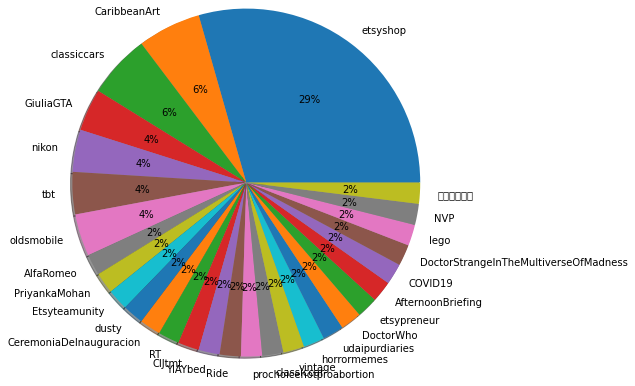

In [152]:
#----- DISPLAY RESULT --------#
""" Display Results """
print('Top 10 hashtags')
#top_number = int(input())
top_number = 10

#Keywods
print('\nKeywords used in search : ')
print(userInput +'\n')

#Top 10 hashtags of the week
print('Top 10 Hashtags of the week : ')
print(displayTopOfWeek(tweets_array, top_number))

#Top 10 hashtags for each latest 7 days 
print('Top 10 Hashtags for each latest 7 days : ')
print(displayTopOfDays(tweets_array, 7, top_number))

#Top10 hashtags per hours 
print('Top 10 Hashtags for each hour of today')
print(displayTopPerHour(tweets_array, 7, top_number))

#General Details
print('Benchmarking')

#Chorometer counts
print('\033[4m' + 'Total time spent to get results' + '\033[0m' + ':', end =" ")
print(str(tweets.getChronoRecord()) + ' seconds') 
#Total rows caught from api
print('\033[4m' + 'Total rows found from api' + '\033[0m' + ':', end =" ")
print(str(tweets.getTotalRows()) + ' rows') 

print("\nPie chart of each hashtag's occurences found in twitter list")
createPieChart(hashtag_occurence)